# Visualizing the prediction results of *VNet2d*

### Importing required packages

In [9]:
import torch  
from torchvision import transforms  
from PIL import Image  
import matplotlib.pyplot as plt 
import numpy as np
import cv2

from model import VNet  # Import the model
from loader import load_data  # Import the DataLoader for the validation set
from ellipse_functions import fit_ellipse_from_mask, create_ellipse_mask  # Import ellipse functions
from metrics_functions import calculate_metrics  # Import metrics functions

### Initializing model and loading test image and mask

In [3]:
# Initialize the model
model = VNet()
model.load_state_dict(torch.load('./model/vnet_2d_model.pth', weights_only=True))
model.eval()  # Set the model to evaluation mode

# Load and preprocess the image
image_path = '../data/val_resized/slices/0d0a3298-a9c6-43c3-a9e3-df3a9c0afa06_slice_45.png'
mask_path = '../data/val_resized/masks/0d0a3298-a9c6-43c3-a9e3-df3a9c0afa06_slice_45_mask.png'
image = Image.open(image_path).convert('L')  # Convert to grayscale
mask = Image.open(mask_path).convert('L')  # Convert to grayscale

### Using model for predictions

In [4]:

# Transform the image to a tensor and add a batch dimension
image_tensor = transforms.ToTensor()(image).unsqueeze(0)  # Shape should be [1, 1, H, W]

# Predict the mask
with torch.no_grad():
    output = model(image_tensor)  # Forward pass with the input image
    output = torch.sigmoid(output)  # Apply sigmoid to get values between 0 and 1
    predicted_mask = (output > 0.5).float()  # Binarize the output (1 for values > 0.5, 0 otherwise)

# Convert predicted mask back to a NumPy array for visualization
predicted_mask = predicted_mask.squeeze().cpu().numpy()  # Shape should be [H, W]

### Visualizing predictions

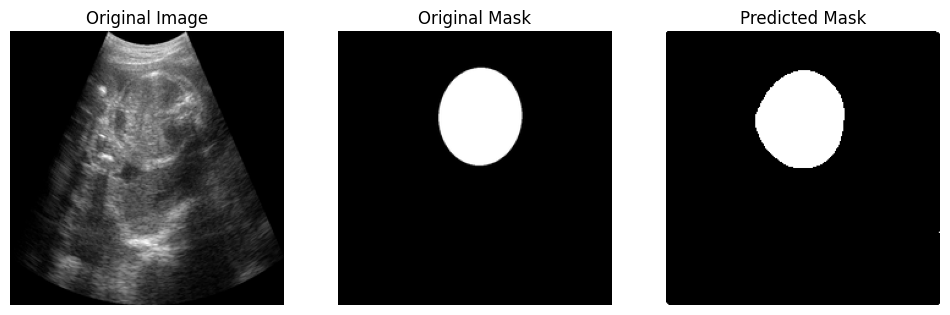

In [5]:

# Plot the original image and the predicted mask
plt.figure(figsize=(12, 6))

# Display the original image
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(image, cmap='gray')
plt.axis('off')

# Display the original mask
plt.subplot(1, 3, 2)
plt.title("Original Mask")
plt.imshow(mask, cmap='gray')
plt.axis('off')

# Display the predicted mask
plt.subplot(1, 3, 3)
plt.title("Predicted Mask")
plt.imshow(predicted_mask, cmap='gray')
plt.axis('off')

plt.show()

### Applying ellipse on predictions

In [6]:
# Find and fit the ellipse on the predicted mask
ellipse = fit_ellipse_from_mask(predicted_mask)

# Create a smooth mask based on the fitted ellipse
if ellipse is not None:
    ellipse_mask = create_ellipse_mask(predicted_mask.shape, ellipse)
else:
    ellipse_mask = np.zeros(predicted_mask.shape, dtype=np.uint8)  # If no ellipse, return an empty mask

### Visualizing ellipse

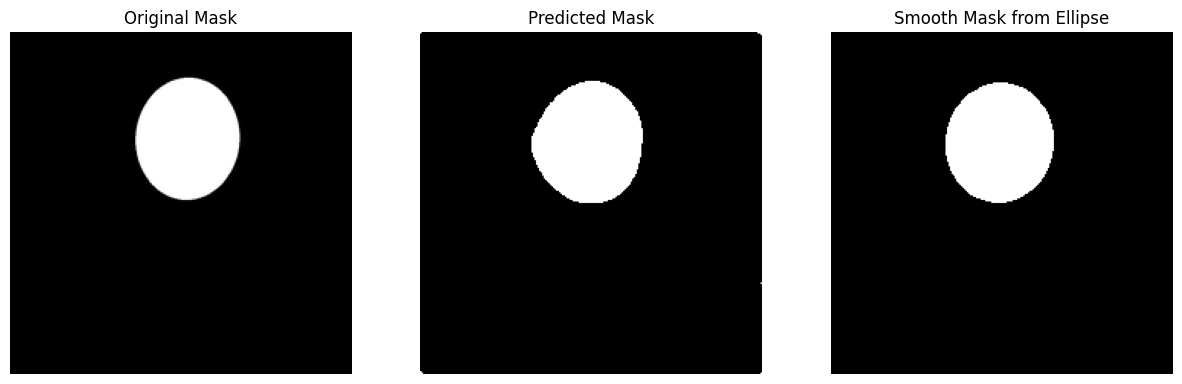

In [7]:
# Visualize the original mask, predicted mask, and the ellipse mask
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(mask, cmap='gray')
plt.title('Original Mask')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(predicted_mask, cmap='gray')
plt.title('Predicted Mask')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(ellipse_mask, cmap='gray')
plt.title('Smooth Mask from Ellipse')
plt.axis('off')

plt.show()

### Calculating the metrics for the model

In [11]:
# Calculate and print metrics
# Define paths for your datasets
train_data_dir = "../data/train_resized/slices"
train_mask_dir = "../data/train_resized/masks"
val_data_dir = "../data/val_resized/slices"
val_mask_dir = "../data/val_resized/masks"
train_loader, val_loader = load_data(train_data_dir, train_mask_dir, val_data_dir, val_mask_dir)

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move model to the correct device
model = model.to(device)
calculate_metrics(val_loader, model)

Average DICE Score on the validation set: 0.9554
Mean Absolute Error (MAE): 0.4716
Mean Squared Error (MSE): 0.2289
Root Mean Squared Error (RMSE): 0.4784
Mean Percentage Error (MPE): 4324521.4844%
R-squared (R²): -1.0830
